## 3 features

In [17]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern, RationalQuadratic, DotProduct, \
    ExpSineSquared
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

class LCSTPredictor:
    def __init__(self):
        self.gpr = None
        self.X_orig = None
        self.y_orig = None
        self.lcst_std_orig = None
        self.X_scaler = None
        self.y_scaler = None
        self.kernel = None
        self.original_data = None

    def prepare_data(self, file_path='25_ver5.xlsx'):
        """Prepare the LCST dataset from Excel file with 3 salt inputs"""
        try:
            # Read Excel file
            df = pd.read_excel(file_path)

            # Calculate mean LCST and std for each condition
            df['LCST_mean'] = df[['LCST_1', 'LCST_2', 'LCST_3']].mean(axis=1)
            df['LCST_std'] = df[['LCST_1', 'LCST_2', 'LCST_3']].std(axis=1)
            df['LCST_std'] = df['LCST_std'].fillna(0.3)

            # Store original data
            self.X_orig = df[['NaCl', 'NaBr', 'CaCl2']].values
            self.y_orig = df['LCST_mean'].values
            self.lcst_std_orig = df['LCST_std'].values
            self.original_data = df

            return self.X_orig, self.y_orig, self.lcst_std_orig

        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def create_model(self):
        """Create GPR model with optimized kernel"""
        if self.kernel is None:
            self.kernel = ConstantKernel(1.0) * Matern(length_scale=[0.5, 1.0, 1.0], nu=1) + \
                          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-12, 1e1))

        return GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=100,
            random_state=42
        )

    def optimize_kernel(self):
        """Try different kernel configurations and return the best one"""
        if self.X_orig is None or self.y_orig is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

    # Initialize scalers here
        self.X_scaler = StandardScaler().fit(self.X_orig)
        self.y_scaler = StandardScaler().fit(self.y_orig.reshape(-1, 1))

    # Define different kernels to try with better bounds
        kernels = [

        ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)) +
        ConstantKernel(0.707, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=[0.8, 1.0, 1.2], length_scale_bounds=(1e-2, 1e2)) + ConstantKernel(0.548, constant_value_bounds=(1e-3, 1e3)) * Matern(length_scale=[0.9, 1.1, 1.3], length_scale_bounds=(1e-2, 1e2), nu=2.5) + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-10, 1.0))

        ]

        best_r2 = -np.inf
        best_kernel = None
        best_mae = np.inf
        best_rmse = np.inf
        best_gpr = None

        # Perform LOO CV for each kernel
        for i, kernel in enumerate(kernels):
            try:
                self.kernel = kernel
                r2, mae, rmse = self.leave_one_out_cv()
                # print(f"Kernel: {kernel}")
                # print(f"R² Score: {r2:.3f}, MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C")

                if r2 > best_r2:
                    best_r2 = r2
                    best_kernel = kernel
                    best_mae = mae
                    best_rmse = rmse
                    best_gpr = self.gpr  # Store the trained model


            except Exception as e:
                print(f"Error with kernel {i+1}: {str(e)}")

        # if best_gpr is not None and hasattr(best_gpr, 'kernel_'):
        #     print(f"Optimized kernel parameters: {best_gpr.kernel_}")

        # Set the best model and kernel
        self.gpr = best_gpr
        self.kernel = best_kernel

        return best_kernel, best_r2, best_mae, best_rmse


    def leave_one_out_cv(self):
        """Perform LOO CV with proper scaling within each fold"""
        if self.X_orig is None or self.y_orig is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        loo = LeaveOneOut()
        y_pred_all = []
        y_std_all = []

        for train_idx, test_idx in loo.split(self.X_orig):
            # Split data
            X_train, X_test = self.X_orig[train_idx], self.X_orig[test_idx]
            y_train, y_test = self.y_orig[train_idx], self.y_orig[test_idx]

            # Scale features and target within fold
            X_scaler = StandardScaler().fit(X_train)
            y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

            X_train_scaled = X_scaler.transform(X_train)
            X_test_scaled = X_scaler.transform(X_test)
            y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()

            # Train and predict
            model = self.create_model()
            model.fit(X_train_scaled, y_train_scaled)
            y_pred, y_std = model.predict(X_test_scaled, return_std=True)

            # Transform predictions back to original scale
            y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
            y_std_orig = y_std * y_scaler.scale_

            y_pred_all.append(y_pred_orig[0])
            y_std_all.append(y_std_orig[0])

        # Calculate metrics
        y_pred_all = np.array(y_pred_all)
        y_std_all = np.array(y_std_all)

        r2 = r2_score(self.y_orig, y_pred_all)
        mae = mean_absolute_error(self.y_orig, y_pred_all)
        rmse = np.sqrt(mean_squared_error(self.y_orig, y_pred_all))

        # Create parity plot
        self._create_parity_plot(y_pred_all, y_std_all)

        # Fit final model on all data
        self.X_scaler = StandardScaler().fit(self.X_orig)
        self.y_scaler = StandardScaler().fit(self.y_orig.reshape(-1, 1))

        X_scaled = self.X_scaler.transform(self.X_orig)
        y_scaled = self.y_scaler.transform(self.y_orig.reshape(-1, 1)).ravel()

        self.gpr = self.create_model()
        self.gpr.fit(X_scaled, y_scaled)

        return r2, mae, rmse

    def _create_parity_plot(self, y_pred, y_std):
        """Create parity plot for model evaluation"""
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot diagonal line
        min_val = min(self.y_orig.min(), y_pred.min())
        max_val = max(self.y_orig.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], '--', color='grey')

        # Plot predictions with error bars
        ax.errorbar(self.y_orig, y_pred,
                    xerr=self.lcst_std_orig,
                    yerr=y_std,
                    fmt='o', color='blue', markersize=8,
                    capsize=5, label='Predictions')

        ax.set_xlabel('Experimental LCST (°C)')
        ax.set_ylabel('Predicted LCST (°C)')
        ax.legend()
        ax.grid(False)
        plt.tight_layout()
        plt.show()

    def optimize_concentrations(self, target_lcst):
        """Find optimal concentrations for target LCST"""
        if not hasattr(self.gpr, 'X_train_'):
            raise ValueError("Model not trained. Run leave_one_out_cv first.")

        # Create grid of points
        grid_points = 100  # Reduced for efficiency
        ranges = [np.linspace(0.1, 1, grid_points) for _ in range(3)]
        grid_coords = np.array(np.meshgrid(*ranges))
        grid_points = grid_coords.reshape(3, -1).T

        # Scale grid points and target
        grid_points_std = self.X_scaler.transform(grid_points)
        target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

        # Get predictions
        y_pred, y_std = self.gpr.predict(grid_points_std, return_std=True)

        # Calculate Expected Improvement
        diff = np.abs(y_pred - target_lcst_norm)
        improvement = -diff
        z = improvement / y_std
        ei = (improvement * norm.cdf(z) + y_std * norm.pdf(z))

        # Find optimal point
        max_ei_idx = np.argmax(ei)
        optimal_point = grid_points[max_ei_idx]
        score = diff[max_ei_idx]

        return optimal_point, score

    def plot_lcst_slice(self, fixed_salt, fixed_conc, target_lcst=None, resolution=100, custom_point=None):
        """Plot 2D LCST contour slice with one salt concentration fixed"""
        if not hasattr(self.gpr, 'X_train_'):
            raise ValueError("Model not trained. Run leave_one_out_cv first.")

        # Apply plotting style
        self.set_plotting_style()

        # Define salt mapping
        salt_indices = {'NaCl': 0, 'NaBr': 1, 'CaCl2': 2}

        # Define axes mapping for each fixed salt
        axes_mapping = {
            'NaCl': {'x': 'NaBr', 'y': 'CaCl2', 'x_idx': 1, 'y_idx': 2},
            'NaBr': {'x': 'NaCl', 'y': 'CaCl2', 'x_idx': 0, 'y_idx': 2},
            'CaCl2': {'x': 'NaCl', 'y': 'NaBr', 'x_idx': 0, 'y_idx': 1}
        }

        # Get axis indices
        x_idx = axes_mapping[fixed_salt]['x_idx']
        y_idx = axes_mapping[fixed_salt]['y_idx']
        fixed_idx = salt_indices[fixed_salt]

        # Create 2D grid - starting from 0.0 to match your figure
        x_range = np.linspace(0.1, 1, resolution)
        y_range = np.linspace(0.1, 1, resolution)
        X1, X2 = np.meshgrid(x_range, y_range)

        # Create 3D points with fixed salt
        grid_points = np.zeros((X1.size, 3))
        grid_points[:, x_idx] = X1.ravel()
        grid_points[:, y_idx] = X2.ravel()
        grid_points[:, fixed_idx] = fixed_conc

        # Scale grid points
        grid_points_std = self.X_scaler.transform(grid_points)

        # Get predictions
        y_pred, y_std = self.gpr.predict(grid_points_std, return_std=True)

        # Transform predictions back to original scale
        y_pred_orig = self.y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        y_std_orig = y_std * self.y_scaler.scale_

        # Reshape for plotting
        Z_pred = y_pred_orig.reshape(X1.shape)
        Z_std = y_std_orig.reshape(X1.shape)

        # Create figure
        fig, ax = plt.subplots()

        # Plot LCST contour with smoother appearance and no grid lines
        contour = ax.contourf(X1, X2, Z_pred, levels=15, cmap='viridis', alpha=1.0)

        # Add colorbar with specific formatting
        cbar = plt.colorbar(contour)
        cbar.set_label('LCST (°C)')

        # Plot all experimental data points (projection onto this slice)
        # Get the x and y coordinates for all experimental points
        exp_x = self.X_orig[:, x_idx]
        exp_y = self.X_orig[:, y_idx]

        # Plot all experimental points with larger, more visible markers
        scatter = ax.scatter(exp_x, exp_y,
                             c='red', marker='o', s=120,
                             label='Experimental Data')

        # If target LCST is provided, plot the contour line for that LCST
        if target_lcst is not None:
            target_contour = ax.contour(X1, X2, Z_pred, levels=[target_lcst],
                                        colors='red', linewidths=2, linestyles='solid')
            ax.clabel(target_contour, inline=True, fontsize=12, fmt=f'{target_lcst}°C')

            # If custom point is provided, use it instead of calculating EI
            if custom_point is not None:
                # Extract x and y coordinates for the custom point
                max_ei_x = custom_point[x_idx]
                max_ei_y = custom_point[y_idx]

                # Create full 3D point for prediction
                max_ei_point = np.zeros(3)
                max_ei_point[x_idx] = max_ei_x
                max_ei_point[y_idx] = max_ei_y
                max_ei_point[fixed_idx] = fixed_conc

                # Calculate predicted LCST at custom point
                max_ei_scaled = self.X_scaler.transform(max_ei_point.reshape(1, -1))
                pred_lcst, std = self.gpr.predict(max_ei_scaled, return_std=True)
                pred_lcst = self.y_scaler.inverse_transform(pred_lcst.reshape(-1, 1))[0][0]

                # Plot custom point
                ax.scatter(max_ei_x, max_ei_y, c='yellow', marker='*', s=300,
                           edgecolors='black', linewidth=1, zorder=10,
                           label='EI Candidate')

                # Add annotation for custom point with bright background
                x_salt = axes_mapping[fixed_salt]['x']
                y_salt = axes_mapping[fixed_salt]['y']
                ax.annotate(f'{x_salt}: {max_ei_x:.3f}\n{y_salt}: {max_ei_y:.3f}',
                            xy=(max_ei_x, max_ei_y), xytext=(10, 10),
                            textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7))
            else:
                # Calculate EI and find maximum point
                target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

                # Calculate EI
                diff = np.abs(y_pred - target_lcst_norm)
                improvement = -diff
                z = improvement / y_std
                ei = (improvement * norm.cdf(z) + y_std * norm.pdf(z))
                EI = ei.reshape(X1.shape)

                # Find maximum EI point
                max_ei_idx = np.unravel_index(np.argmax(EI), EI.shape)
                max_ei_x = X1[max_ei_idx]
                max_ei_y = X2[max_ei_idx]

                # Create full 3D point for prediction
                max_ei_point = np.zeros(3)
                max_ei_point[x_idx] = max_ei_x
                max_ei_point[y_idx] = max_ei_y
                max_ei_point[fixed_idx] = fixed_conc

                # Calculate predicted LCST at maximum EI
                max_ei_scaled = self.X_scaler.transform(max_ei_point.reshape(1, -1))
                pred_lcst, std = self.gpr.predict(max_ei_scaled, return_std=True)
                pred_lcst = self.y_scaler.inverse_transform(pred_lcst.reshape(-1, 1))[0][0]

                # Plot max EI point
                ax.scatter(max_ei_x, max_ei_y, c='yellow', marker='*', s=300,
                           edgecolors='black', linewidth=1, zorder=10,
                           label='EI Candidate')

                # Add annotation for max EI point
                x_salt = axes_mapping[fixed_salt]['x']
                y_salt = axes_mapping[fixed_salt]['y']

        # Set labels and title
        x_label = axes_mapping[fixed_salt]['x']
        y_label = axes_mapping[fixed_salt]['y']
        # Use LaTeX notation for salt names in axis labels
        x_label_formatted = f'$CaCl_2$' if x_label == 'CaCl2' else (f'$NaCl$' if x_label == 'NaCl' else f'$NaBr$')
        y_label_formatted = f'$CaCl_2$' if y_label == 'CaCl2' else (f'$NaCl$' if y_label == 'NaCl' else f'$NaBr$')
        ax.set_xlabel(f'{x_label_formatted} (mol/L)')
        ax.set_ylabel(f'{y_label_formatted} (mol/L)')
        ax.set_title(f'LCST Prediction Map')

        # Set axis limits - starting from 0.0 to match your figure
        ax.set_xlim(0.1, 1)
        ax.set_ylim(0.1, 1)

        # Remove grid lines
        ax.grid(False)

        # Add legend with custom styling - make it more visible
        legend = ax.legend(loc='upper right', frameon=True)
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_alpha(0.7)

        plt.tight_layout()
        return fig

    def plot_expected_improvement(self, target_lcst, fixed_cacl2=0.5):
        """Plot 2D Expected Improvement surface"""
        if not hasattr(self.gpr, 'X_train_'):
            raise ValueError("Model not trained. Run leave_one_out_cv first.")

        # Create 2D grid
        grid_points = 100
        x_range = np.linspace(0.1, 1, grid_points)
        y_range = np.linspace(0.1, 1, grid_points)
        X1, X2 = np.meshgrid(x_range, y_range)

        # Create 3D points with fixed CaCl2
        grid_points = np.column_stack((X1.ravel(), X2.ravel(),
                                       np.full(X1.size, fixed_cacl2)))

        # Scale points and target
        grid_points_std = self.X_scaler.transform(grid_points)
        target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

        # Get predictions
        y_pred, y_std = self.gpr.predict(grid_points_std, return_std=True)

        # Calculate EI
        diff = np.abs(y_pred - target_lcst_norm)
        improvement = -diff
        z = improvement / y_std
        ei = (improvement * norm.cdf(z) + y_std * norm.pdf(z))
        EI = ei.reshape(X1.shape)

        # Find maximum EI point
        max_ei_idx = np.unravel_index(np.argmax(EI), EI.shape)
        max_ei_point = np.array([X1[max_ei_idx], X2[max_ei_idx], fixed_cacl2])

        # Calculate predicted LCST at maximum EI
        max_ei_scaled = self.X_scaler.transform(max_ei_point.reshape(1, -1))
        pred_lcst, std = self.gpr.predict(max_ei_scaled, return_std=True)
        pred_lcst = self.y_scaler.inverse_transform(pred_lcst.reshape(-1, 1))[0][0]

        # Create plot
        plt.figure(figsize=(8, 8))
        plt.rcParams['font.size'] = 12

        contour = plt.contourf(X1, X2, EI, levels=50, cmap='YlOrRd_r')
        plt.scatter(self.X_orig[:, 0], self.X_orig[:, 1],
                    c='red', marker='o', s=50, label='Experimental Data')
        plt.scatter(max_ei_point[0], max_ei_point[1],
                    c='green', marker='*', s=200, label='Maximum EI')

        plt.xlabel('$NaCl$ (mol/L)')
        plt.ylabel('$NaBr$ (mol/L)')
        plt.title(f'Expected Improvement ($CaCl_2$ = {fixed_cacl2})')
        plt.legend(frameon=True, facecolor='white')
        plt.colorbar(contour, label='Expected Improvement')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

        print(f"\nMaximum Expected Improvement Point:")
        print(f"NaCl: {max_ei_point[0]:.3f} mol/L")
        print(f"NaBr: {max_ei_point[1]:.3f} mol/L")
        print(f"CaCl₂: {max_ei_point[2]:.3f} mol/L")
        print(f"Predicted LCST: {pred_lcst:.2f}°C")

        return max_ei_point

    def calculate_volumes(self, concentrations):
        """Calculate required volumes for given concentrations"""
        stock_concs = {'NaCl': 1, 'NaBr': 2, 'CaCl2': 1}  # M
        total_volume = 800  # μL

        volumes = {}
        for i, (salt, conc) in enumerate(zip(['NaCl', 'NaBr', 'CaCl2'], concentrations)):
            volumes[salt] = (conc * total_volume) / stock_concs[salt]

        volumes['water'] = total_volume - sum(volumes.values())

        if volumes['water'] < 0:
            raise ValueError(f"Invalid solution - negative water volume: {volumes['water']:.1f} μL")

        return volumes

    def set_plotting_style(self):
        """Set consistent plotting style for all figures"""
        plt.rcParams['figure.figsize'] = [6, 4]
        plt.rcParams['axes.labelweight'] = 'bold'
        plt.rcParams['font.size'] = 15

        # Set x axis
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.major.width'] = 1
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['xtick.minor.width'] = 1

        # Set y axis
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['ytick.minor.width'] = 1

        # Fontsizes
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        plt.rcParams['legend.fontsize'] = 16
        plt.rcParams['legend.title_fontsize'] = 16
        plt.rcParams['axes.labelsize'] = 16
        plt.rcParams['axes.titlesize'] = 16

        # Set line widths
        plt.rcParams['axes.linewidth'] = 1
        plt.rcParams['grid.linewidth'] = 1
        plt.rcParams['lines.linewidth'] = 2

        # Set title and font
        plt.rcParams['figure.titlesize'] = 20
        plt.rcParams['font.family'] = 'Arial'

    def plot_expected_improvement_slice(self, fixed_salt, fixed_conc, target_lcst, resolution=100, custom_point=None):
        """Plot 2D Expected Improvement slice with one salt concentration fixed"""
        if not hasattr(self.gpr, 'X_train_'):
            raise ValueError("Model not trained. Run leave_one_out_cv first.")

        # Apply plotting style
        self.set_plotting_style()

        # Define salt mapping
        salt_indices = {'NaCl': 0, 'NaBr': 1, 'CaCl2': 2}

        # Define axes mapping for each fixed salt
        axes_mapping = {
            'NaCl': {'x': 'NaBr', 'y': 'CaCl2', 'x_idx': 1, 'y_idx': 2},
            'NaBr': {'x': 'NaCl', 'y': 'CaCl2', 'x_idx': 0, 'y_idx': 2},
            'CaCl2': {'x': 'NaCl', 'y': 'NaBr', 'x_idx': 0, 'y_idx': 1}
        }

        # Get axis indices
        x_idx = axes_mapping[fixed_salt]['x_idx']
        y_idx = axes_mapping[fixed_salt]['y_idx']
        fixed_idx = salt_indices[fixed_salt]

        # Create 2D grid
        x_range = np.linspace(0.1, 1, resolution)
        y_range = np.linspace(0.1, 1, resolution)
        X1, X2 = np.meshgrid(x_range, y_range)

        # Create 3D points with fixed salt
        grid_points = np.zeros((X1.size, 3))
        grid_points[:, x_idx] = X1.ravel()
        grid_points[:, y_idx] = X2.ravel()
        grid_points[:, fixed_idx] = fixed_conc

        # Scale grid points
        grid_points_std = self.X_scaler.transform(grid_points)
        target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

        # Get predictions
        y_pred, y_std = self.gpr.predict(grid_points_std, return_std=True)

        # Calculate EI
        diff = np.abs(y_pred - target_lcst_norm)
        improvement = -diff
        z = improvement / y_std
        ei = (improvement * norm.cdf(z) + y_std * norm.pdf(z))
        EI = ei.reshape(X1.shape)

        # Create figure
        fig, ax = plt.subplots()
        from matplotlib.colors import LinearSegmentedColormap
        colors = [(0, 0, 0.5), (0, 0, 0.8), (0.9, 0.9, 0), (1, 1, 0)]
        cmap_name = 'blue_to_yellow'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

        # Plot EI contour with the custom colormap
        contour = ax.contourf(X1, X2, EI, levels=20, cmap='plasma', alpha=1.0)

        # Add colorbar with vertical orientation
        cbar = plt.colorbar(contour, orientation='vertical')
        cbar.set_label('Expected Improvement')

        # Plot all experimental data points
        exp_x = self.X_orig[:, x_idx]
        exp_y = self.X_orig[:, y_idx]

        scatter = ax.scatter(exp_x, exp_y,
                           c='red', marker='o', s=120,
                           label='Experimental Data')

        # If custom point is provided, use it instead of calculating EI
        if custom_point is not None:
            # Extract x and y coordinates for the custom point
            max_ei_x = custom_point[x_idx]
            max_ei_y = custom_point[y_idx]

            # Create full 3D point for prediction
            max_ei_point = np.zeros(3)
            max_ei_point[x_idx] = max_ei_x
            max_ei_point[y_idx] = max_ei_y
            max_ei_point[fixed_idx] = fixed_conc

            # Calculate predicted LCST at custom point
            max_ei_scaled = self.X_scaler.transform(max_ei_point.reshape(1, -1))
            pred_lcst, std = self.gpr.predict(max_ei_scaled, return_std=True)
            pred_lcst = self.y_scaler.inverse_transform(pred_lcst.reshape(-1, 1))[0][0]

            # Plot custom point
            ax.scatter(max_ei_x, max_ei_y, c='yellow', marker='*', s=300,
                      edgecolors='black', linewidth=1, zorder=10,
                      label='EI Candidate')
        else:
            # Find maximum EI point
            max_ei_idx = np.unravel_index(np.argmax(EI), EI.shape)
            max_ei_x = X1[max_ei_idx]
            max_ei_y = X2[max_ei_idx]

            # Create full 3D point for prediction
            max_ei_point = np.zeros(3)
            max_ei_point[x_idx] = max_ei_x
            max_ei_point[y_idx] = max_ei_y
            max_ei_point[fixed_idx] = fixed_conc

            # Calculate predicted LCST at maximum EI
            max_ei_scaled = self.X_scaler.transform(max_ei_point.reshape(1, -1))
            pred_lcst, std = self.gpr.predict(max_ei_scaled, return_std=True)
            pred_lcst = self.y_scaler.inverse_transform(pred_lcst.reshape(-1, 1))[0][0]

            # Plot max EI point
            ax.scatter(max_ei_x, max_ei_y, c='yellow', marker='*', s=300,
                      edgecolors='black', linewidth=1, zorder=10,
                      label='EI Candidate')

        # Set labels and title
        x_label = axes_mapping[fixed_salt]['x']
        y_label = axes_mapping[fixed_salt]['y']
        # Use LaTeX notation for salt names in axis labels
        x_label_formatted = f'$CaCl_2$' if x_label == 'CaCl2' else (f'$NaCl$' if x_label == 'NaCl' else f'$NaBr$')
        y_label_formatted = f'$CaCl_2$' if y_label == 'CaCl2' else (f'$NaCl$' if y_label == 'NaCl' else f'$NaBr$')
        ax.set_xlabel(f'{x_label_formatted} (mol/L)')
        ax.set_ylabel(f'{y_label_formatted} (mol/L)')
        # Use LaTeX notation for all salts in the title
        if fixed_salt == 'CaCl2':
            ax.set_title(f'EI (Target LCST: {target_lcst}°C)\n Fix $CaCl_2$ at {fixed_conc:.2f} mol/L')
        elif fixed_salt == 'NaCl':
            ax.set_title(f'EI (Target LCST: {target_lcst}°C)\n Fix $NaCl$ at {fixed_conc:.2f} mol/L')
        elif fixed_salt == 'NaBr':
            ax.set_title(f'EI (Target LCST: {target_lcst}°C)\n Fix $NaBr$ at {fixed_conc:.2f} mol/L')

        # Set axis limits
        ax.set_xlim(0.1, 1)
        ax.set_ylim(0.1, 1)

        # Remove grid lines
        ax.grid(False)

        # Add legend
        legend = ax.legend(loc='upper right', frameon=True)
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_alpha(0.7)

        plt.tight_layout()
        return fig

    def explore_salt_concentrations(self, target_lcst=None):
        """Interactive exploration of LCST with varying salt concentrations"""
        try:
            from ipywidgets import interactive, FloatSlider, Button, VBox, HBox, Dropdown, Text, Label, RadioButtons
            from IPython.display import display
        except ImportError:
            print("ipywidgets not installed. Using basic matplotlib interaction.")
            return

        # Define the salts
        salts = ['NaCl', 'NaBr', 'CaCl2']

        # Create a state container to store current figure and parameters
        class State:
            def __init__(self):
                self.fig = None
                self.salt = salts[0]
                self.conc = 0.5
                self.target = target_lcst
                self.custom_point = None
                self.view_mode = 'LCST'  # Default view mode

        state = State()

        # Create a save button for saving the figure
        save_button = Button(description="Save Figure")

        def on_save_clicked(b):
            try:
                fig = state.fig
                if fig is None:
                    print("No figure to save!")
                    return
                fig.canvas.draw_idle()
                plt.draw()
                view_type = "lcst" if state.view_mode == "LCST" else "ei"
                filename = f"/Users/xuguoyue/Documents/GitHub/Automatic-platform/Figuremaking/7initial/25verification_last round/{view_type}_slice_{state.salt}_{state.conc:.2f}.png"
                fig.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Figure saved successfully as '{filename}'")
            except Exception as e:
                print(f"Error saving figure: {str(e)}")

        save_button.on_click(on_save_clicked)

        # Create text inputs for custom point coordinates
        nacl_input = Text(value='0.5', description='$NaCl$:')
        nabr_input = Text(value='0.5', description='$NaBr$:')
        cacl2_input = Text(value='0.5', description='$CaCl_2$:')

        # Create a button to set the custom point
        set_point_button = Button(description="Set Custom Point")

        def on_set_point_clicked(b):
            try:
                # Parse input values
                nacl_val = float(nacl_input.value)
                nabr_val = float(nabr_input.value)
                cacl2_val = float(cacl2_input.value)

                # Validate input values
                if not (0.0 <= nacl_val <= 1.2 and 0.0 <= nabr_val <= 1.2 and 0.0 <= cacl2_val <= 1.2):
                    print("Values must be between 0.0 and 1.2")
                    return

                # Set custom point
                state.custom_point = np.array([nacl_val, nabr_val, cacl2_val])

                # Update plot
                update_plot(state.salt, state.conc)

                print(f"Custom point set to: NaCl={nacl_val}, NaBr={nabr_val}, CaCl₂={cacl2_val}")
            except ValueError:
                print("Invalid input. Please enter numeric values.")

        set_point_button.on_click(on_set_point_clicked)

        # Create view mode selector
        view_mode_selector = RadioButtons(
            options=['LCST', 'EI'],
            description='View:',
            disabled=False
        )

        def on_view_mode_change(change):
            state.view_mode = change['new']
            update_plot(state.salt, state.conc)

        view_mode_selector.observe(on_view_mode_change, names='value')

        def update_plot(fixed_salt, fixed_conc, resolution=100):
            # Update state values
            state.salt = fixed_salt
            state.conc = fixed_conc

            # Generate the plot based on view mode
            if state.view_mode == 'LCST':
                fig = self.plot_lcst_slice(fixed_salt, fixed_conc, state.target, resolution, state.custom_point)
            else:  # EI mode
                if state.target is None:
                    print("Target LCST is required for EI view")
                    return None
                fig = self.plot_expected_improvement_slice(fixed_salt, fixed_conc, state.target, resolution, state.custom_point)

            state.fig = fig

            plt.draw()
            return fig

        # Create interactive widgets for selecting the fixed salt and concentration
        fixed_salt_widget = Dropdown(options=salts, value=salts[0], description='Fixed Salt:')
        conc_slider = FloatSlider(min=0.1, max=1.0, step=0.01, value=0.5, description='Concentration (mol/L):')

        # Create the interactive plot
        plot_widget = interactive(
            update_plot,
            fixed_salt=fixed_salt_widget,
            fixed_conc=conc_slider,
            resolution=(50, 200, 25)
        )

        # Create layout for custom point inputs
        custom_point_label = Label(value="Set Custom Point Coordinates:")
        custom_point_inputs = HBox([nacl_input, nabr_input, cacl2_input, set_point_button])

        # Display the interactive widget, view selector, custom point inputs, and the save button
        display(VBox([
            HBox([view_mode_selector]),
            plot_widget,
            custom_point_label,
            custom_point_inputs,
            save_button
        ]))

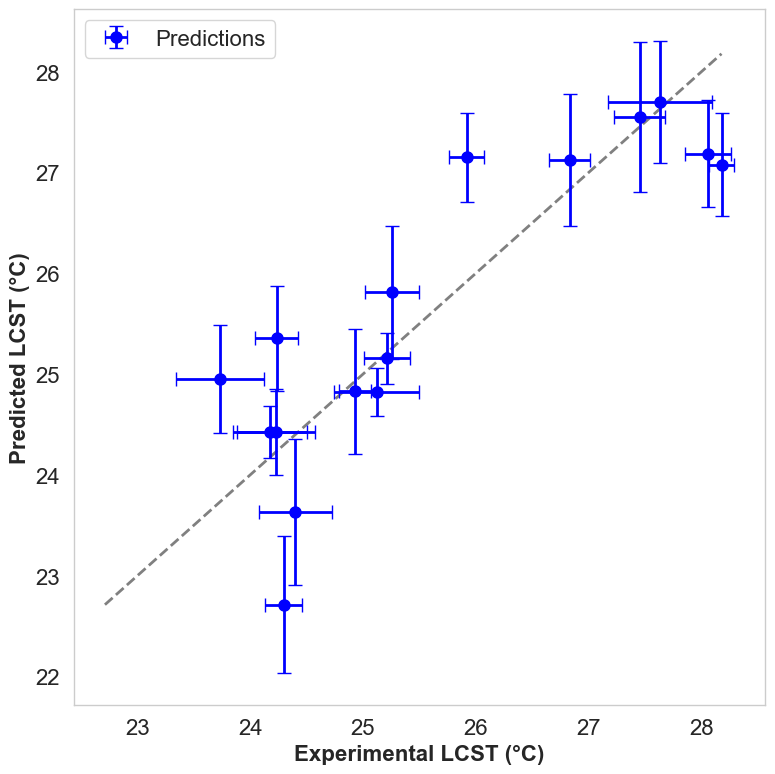


Best Model Performance:
R² Score: 0.718
Mean Absolute Error: 0.61°C
Root Mean Squared Error: 0.79°C

Final optimized kernel parameters:
1.16**2 * DotProduct(sigma_0=1e-05) + 0.327**2 * RBF(length_scale=[0.334, 1.87, 0.535]) + 0.247**2 * Matern(length_scale=[0.0139, 100, 100], nu=2.5) + WhiteKernel(noise_level=1e-10)

Optimizing for target LCST = 25°C...

Optimal concentrations:
NaCl: 0.736 mol/L
NaBr: 0.100 mol/L
CaCl₂: 0.236 mol/L
Optimization score: 0.0003


In [18]:
predictor = LCSTPredictor()

# Prepare data
X, y, y_std = predictor.prepare_data()

# Optimize kernel
try:
    best_kernel, best_r2, best_mae, best_rmse = predictor.optimize_kernel()

    print("\nBest Model Performance:")
    print(f"R² Score: {best_r2:.3f}")
    print(f"Mean Absolute Error: {best_mae:.2f}°C")
    print(f"Root Mean Squared Error: {best_rmse:.2f}°C")

    # Print optimized kernel parameters
    if hasattr(predictor, 'gpr') and predictor.gpr is not None:
        print("\nFinal optimized kernel parameters:")
        print(predictor.gpr.kernel_)
    else:
        print("\nNo optimized kernel available.")

    # Optimize for target LCST
    target_lcst = 25

    print(f"\nOptimizing for target LCST = {target_lcst}°C...")
    optimal_conc, score = predictor.optimize_concentrations(target_lcst)

    print("\nOptimal concentrations:")
    print(f"NaCl: {optimal_conc[0]:.3f} mol/L")
    print(f"NaBr: {optimal_conc[1]:.3f} mol/L")
    print(f"CaCl₂: {optimal_conc[2]:.3f} mol/L")
    print(f"Optimization score: {score:.4f}")

except Exception as e:
    print(f"Error during kernel optimization: {str(e)}")